In [98]:
#Importando librerias
import wget
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from funpymodeling.exploratory import freq_tbl
import calendar

#Definiendo las variables globales
global df_traffic, resultados, modelo, modelo_clasificacion

In [99]:
#Extraemos el contenido del DataFrame y aplicamos la función preprocesamiento y tomamos una muestra para verificar las columnas desplegadas
df_traffic = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/traffic_site.csv', dtype={'date':object,'fullVisitorId':object,'visitId':object})
df_traffic.sample(5)

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
8735,Direct,20170327,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9222600470100122972,"{""continent"": ""Europe"", ""subContinent"": ""Weste...",9222600470100122972_1490675317,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1490675317,1,1490675317
946,Social,20160917,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",869282477973113307,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",0869282477973113307_1474103678,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""1"",...","{""referralPath"": ""/yt/about/"", ""campaign"": ""(n...",1474103678,1,1474103678
4915,Organic Search,20170406,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",4366259308022048253,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",4366259308022048253_1491542986,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""6"", ""pageviews"": ""6""}","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1491542986,2,1491542986
4630,Organic Search,20170721,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7534701131246087988,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",7534701131246087988_1500679070,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1500679070,2,1500679070
6553,Social,20161031,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",5860506144542258913,"{""continent"": ""Europe"", ""subContinent"": ""South...",5860506144542258913_1477970829,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""referralPath"": ""/yt/about/"", ""campaign"": ""(n...",1477970829,1,1477970829


¿Cuales son las dimensiones del DataFrame?

In [100]:
#Verificamos el número de columnas y filas contenidas en el DataFrame y su tipo de dato asignado a cada una
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   channelGrouping       12283 non-null  object
 1   date                  12283 non-null  object
 2   device                12283 non-null  object
 3   fullVisitorId         12283 non-null  object
 4   geoNetwork            12283 non-null  object
 5   sessionId             12283 non-null  object
 6   socialEngagementType  12283 non-null  object
 7   totals                12283 non-null  object
 8   trafficSource         12283 non-null  object
 9   visitId               12283 non-null  object
 10  visitNumber           12283 non-null  int64 
 11  visitStartTime        12283 non-null  int64 
dtypes: int64(2), object(10)
memory usage: 1.1+ MB


In [101]:
#Verificando si existen nulos en el dataset
df_traffic.isnull().sum()

channelGrouping         0
date                    0
device                  0
fullVisitorId           0
geoNetwork              0
sessionId               0
socialEngagementType    0
totals                  0
trafficSource           0
visitId                 0
visitNumber             0
visitStartTime          0
dtype: int64

In [102]:
# Verificamos el tipo de dato contenido en las columnas anidadas
df_traffic.device.value_counts().index

Index(['{"browser": "Chrome", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Windows", "operatingSystemVersion": "not available in demo dataset", "isMobile": false, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "desktop"}',
       '{"browser": "Chrome", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Macintosh", "operatingSystemVersion": "not available in demo dataset", "isMobile": false, "mobileDeviceBr

In [103]:
def preprocesamiento():
    global df_traffic

    # Extraer datos de diccionarios
    diccionarios = ['device','geoNetwork','trafficSource','totals']
    for columna in diccionarios:
        df_traffic = df_traffic.join(pd.DataFrame([json.loads(linea) for linea in df_traffic[columna]]))
    df_traffic = df_traffic.drop(columns=diccionarios)
    # o puedo ustilizar esta otra opción df_traffic.drop(columns=diccionarios, inplace=True)

    #Eliminar las columnas que no requerimos
    df_traffic= df_traffic.drop(columns=['socialEngagementType','browserVersion','browserSize','operatingSystemVersion','mobileDeviceBranding','mobileDeviceModel','mobileInputSelector','mobileDeviceInfo','mobileDeviceMarketingName','flashVersion','language','screenColors','screenResolution','continent','subContinent','country','region','cityId','latitude','longitude','networkLocation','keyword','adwordsClickInfo','isTrueDirect','adContent','campaignCode','networkDomain','visits'])

    # Eliminar duplicados
    df_traffic = df_traffic.drop_duplicates()

    # Reemplazar textos por números
    cuant = ['bounces', 'hits','newVisits','pageviews', 'transactionRevenue']
    for columna in cuant:
        df_traffic[columna] = pd.to_numeric(df_traffic[columna])
    df_traffic[cuant] = df_traffic[cuant].fillna(0)
    df_traffic['transactionRevenue'] = df_traffic['transactionRevenue'] / 1000000


   # Reemplazar números por fechas
    df_traffic['date'] = pd.to_datetime(df_traffic['date'], format='%Y%m%d')
    df_traffic['visitStartTime'] = pd.to_datetime(df_traffic['visitStartTime'], unit='s')



preprocesamiento()
df_traffic.sample(5)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,deviceCategory,metro,city,campaign,source,medium,referralPath,hits,pageviews,bounces,newVisits,transactionRevenue
810,Social,2016-08-31,5762818779063639334,5762818779063639334_1472679918,1472679918,2,2016-08-31 21:45:18,Chrome,Windows,False,desktop,(not set),Antalya,(not set),youtube.com,referral,/yt/about/tr/,1,1,1.0,0.0,0.0
1097,Organic Search,2016-08-22,8082758848088829782,8082758848088829782_1471918152,1471918152,2,2016-08-23 02:09:12,Chrome,Macintosh,False,desktop,not available in demo dataset,not available in demo dataset,(not set),google,organic,NaN,6,6,0.0,0.0,0.0
4237,Organic Search,2017-05-18,403305617372535305,0403305617372535305_1495144260,1495144260,3,2017-05-18 21:51:00,Chrome,Windows,False,desktop,not available in demo dataset,not available in demo dataset,(not set),google,organic,NaN,6,6,0.0,0.0,0.0
11120,Referral,2017-06-28,4317062290347788104,4317062290347788104_1498666143,1498666143,1,2017-06-28 16:09:03,Chrome,Windows,False,desktop,not available in demo dataset,not available in demo dataset,(not set),analytics.google.com,referral,/analytics/web/,1,1,1.0,1.0,0.0
12129,Referral,2017-03-24,2026554020371641410,2026554020371641410_1490378247,1490378247,1,2017-03-24 17:57:27,Firefox,Windows,False,desktop,not available in demo dataset,not available in demo dataset,(not set),google.com,referral,/intl/en/permissions/using-the-logo.html,1,1,1.0,1.0,0.0


In [104]:
#Verificamos el número de columnas y filas contenidas en el DataFrame y su tipo de dato asignado a cada una
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   channelGrouping     12283 non-null  object        
 1   date                12283 non-null  datetime64[ns]
 2   fullVisitorId       12283 non-null  object        
 3   sessionId           12283 non-null  object        
 4   visitId             12283 non-null  object        
 5   visitNumber         12283 non-null  int64         
 6   visitStartTime      12283 non-null  datetime64[ns]
 7   browser             12283 non-null  object        
 8   operatingSystem     12283 non-null  object        
 9   isMobile            12283 non-null  bool          
 10  deviceCategory      12283 non-null  object        
 11  metro               12283 non-null  object        
 12  city                12283 non-null  object        
 13  campaign            12283 non-null  object    

#**3. Exploración y Feature Engineering**


---

In [105]:
#Agregamos nuevas columnas a partir de las columnas "date" y "visitStartTime" para tener más información capaz de resolver preguntas con base en los datos
def feature_engineering():
    global df_traffic, resultados, modelo, modelo_clasificacion
    
    # Crear las nuevas columnas
    df_traffic['year'] = df_traffic['date'].apply(lambda x:x.year)
    df_traffic['month'] = df_traffic['date'].dt.month  # Mes
    df_traffic['quarterMonth'] = df_traffic['date'].dt.quarter  # Trimestre del mes
    df_traffic['day'] = df_traffic['date'].dt.day  # Día
    df_traffic['weekday'] = df_traffic['date'].dt.weekday  # Día de la semana (0: Lunes, 1: Martes, ..., 6: Domingo)
    df_traffic["hour"] = df_traffic["visitStartTime"].dt.hour

feature_engineering()   

In [106]:
#Realizamos la consulta de número de columnas
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   channelGrouping     12283 non-null  object        
 1   date                12283 non-null  datetime64[ns]
 2   fullVisitorId       12283 non-null  object        
 3   sessionId           12283 non-null  object        
 4   visitId             12283 non-null  object        
 5   visitNumber         12283 non-null  int64         
 6   visitStartTime      12283 non-null  datetime64[ns]
 7   browser             12283 non-null  object        
 8   operatingSystem     12283 non-null  object        
 9   isMobile            12283 non-null  bool          
 10  deviceCategory      12283 non-null  object        
 11  metro               12283 non-null  object        
 12  city                12283 non-null  object        
 13  campaign            12283 non-null  object    

#**3.1 Analisis Univariable de las variables categóricas del Dataset**


---


1.- df_traffic["channelGrouping"] # Aporta información valiosa entre 7 categorías, sin Datos Nulos

2.- df_traffic["fullVisitorId"] # Aporta en un porcentaje pequeño información relevante
De la columna frequency, 8780 de los 12283 registros cuentan con frecuencia de 1 y 784 con frecuencia de 2, lo que da un porcentaje acumulado de los primeros 2 valores del 77.92%. Por lo tanto, fuera de esas dos opciones, la cantidad de información para trabajar con el modelo termina siendo muy pequeña. Sin embargo, se conservará la columna.

3.- df_traffic["sessionId"] # Eliminado debido a que el esquema de BigQuery lo determina como obsoleto y recomienda usar fullVisitorId en su lugar.

4.- df_traffic["visitId"] # Eliminado debido a que solo 11 valores de los 12,272 registros tienen una frecuencia de 2, todos los demás tienen una frecuencia de 1, por lo tanto, al ser tan poca la información para comparar, se elimina la columna.

5.- df_traffic["browser"] # Aporta información valiosa con una distribución de más del 90% de los datos en las primeras 3 categorías.

6.- df_traffic["operatingSystem"] # Aporta información valiosa con una distribución de más del 90% de los datos en las primeras 4 categorías.

7.- df_traffic["deviceCategory"] # Aporta información importante distribuida en 3 categorías.

8.- df_traffic["metro"] # El 77.7 % son datos nulos, sin embargo, se conservarán los pocos datos al ser un área de mercado designada desde la que se originan las sesiones.

9.- df_traffic["city"] # Variable que aporta la ciudad de los usuarios, extraída de las direcciones IP o de los IDs geográficos. Sin embargo, cuenta con más de un 50% de datos nulos. Se conserva.

10.- df_traffic["campaign"] # Variable con 95% de valores no establecidos. A consideración de borrarla, se probará su peso en el modelo.

11.- df_traffic["source"] # Aporta información valiosa. El 93% de los datos dentro de sus primeras 5 categorías.

12.- df_traffic["referralPath"] # Verificamos la información aportada por la columna. En este caso, la columna cuenta con menos de 200 registros de las 12276 filas, de los cuales ninguno aporta información importante. Por lo mismo, se decide ser eliminado del modelo.

13.- df_traffic["medium"] # Cuenta con un 16% de nulos. Sin embargo, aporta información valiosa sobre el medio de la fuente de tráfico.


Explicación parametros de Fuente de Trafico [medium]

Tráfico orgánico ("organic"): Este tipo de tráfico proviene de los resultados de búsqueda orgánica en los motores de búsqueda como Google, Bing, Yahoo, entre otros. Es decir, cuando los usuarios encuentran y visitan el sitio web haciendo clic en un enlace que aparece en los resultados de búsqueda sin haber pagado por la posición.

Coste por clic ("cpc"): También conocido como tráfico de pago por clic, se refiere al tráfico que llega al sitio web a través de anuncios de pago en motores de búsqueda, redes de anuncios o plataformas de publicidad en línea. Los anunciantes pagan cada vez que un usuario hace clic en su anuncio y es dirigido al sitio web.

Referencia ("referral"): Este tipo de tráfico proviene de enlaces en otros sitios web diferentes a los motores de búsqueda. Por ejemplo, si otro sitio web incluye un enlace al sitio web en su contenido y los usuarios hacen clic en ese enlace para visitar el sitio, se considera tráfico de referencia.

Tablas de distribución de frecuencias

A través de la librería funpymodeling a través de su función freq_tbl, realizará análisis univariable de las variables categóricas del dataset para determinar en cada fila su frecuencia, su representanción porcentaje y porcentaje acumulado, para usar esta función únicamente es necesario agregar el nombre del DataFrame y de manera automática dará la relación de las variables CATEGÓRICAS, sin embargo. también puede accederse para realizarlo a través de la subconsulta de la columna específica a consultar. 

Ejemplo : freq_tbl(df["Nombre_columna"])

In [107]:
#Función utilizada para el analisis univariable de las columnas con datos categóricos
freq_tbl(df_traffic)

  channelGrouping  frequency  percentage  cumulative_perc
0  Organic Search       5155    0.419686         0.419686
1          Social       3052    0.248473         0.668159
2          Direct       2011    0.163722         0.831881
3        Referral       1438    0.117072         0.948954
4     Paid Search        310    0.025238         0.974192
5      Affiliates        236    0.019214         0.993406
6         Display         77    0.006269         0.999674
7         (Other)          4    0.000326         1.000000

----------------------------------------------------------------

            fullVisitorId  frequency  percentage  cumulative_perc
0      603373162136570069         24    0.001954         0.001954
1     7660377708313228942         24    0.001954         0.003908
2     5310912563447452038         20    0.001628         0.005536
3     3290805371994597664         20    0.001628         0.007164
4     4376572204985925602         19    0.001547         0.008711
...            

In [108]:
#Función para arrojar datos de anpalisis de la variable 
def analyze_city_data(df, columna):
    
    # Mostrar el conteo de los 10 valores que MÁS se repiten en la información de las primeras filas de la columna asignada
    print("\nConteo de los 10 valores que MÁS se repiten en las primeras filas de la columna asignada:")
    print(df[columna].value_counts().head(10))
    

    # Mostrar los primeros valores en orden descendente de la columna asignada
    print("\nPrimeros valores de la columna asignada")
    print(df[columna].head(10))



    # Mostrar estadísticas descriptivas de la columna asignada
    print("\nEstadísticas descriptivas de la columna asignada")
    print(df[columna].describe())

# Llamar a la función con el DataFrame df_traffic
analyze_city_data(df_traffic, "city")


Conteo de los 10 valores que MÁS se repiten en las primeras filas de la columna asignada:
city
not available in demo dataset    6845
Mountain View                     511
(not set)                         450
New York                          394
San Francisco                     304
Sunnyvale                         197
London                            174
San Jose                          144
Los Angeles                       117
Chicago                           111
Name: count, dtype: int64

Primeros valores de la columna asignada
0                        Singapore
1    not available in demo dataset
2                     Buenos Aires
3    not available in demo dataset
4    not available in demo dataset
5                     Buenos Aires
6    not available in demo dataset
7    not available in demo dataset
8    not available in demo dataset
9    not available in demo dataset
Name: city, dtype: object

Estadísticas descriptivas de la columna asignada
count                          

In [109]:
def buscar_repetidos(df, columna, valor_frecuencia):
    # Contar la frecuencia de cada dato dentro de las filas de la columna especificada
    frecuencia_datos = df[columna].value_counts()

    # Filtrar los datos que tienen una frecuencia igual al valor especificado
    datos_frecuencia_var = frecuencia_datos[frecuencia_datos == valor_frecuencia]

    # Mostrar los datos que aparecen con la frecuencia especificada
    print("Datos con frecuencia de", valor_frecuencia, "en la columna", columna, ":")
    print(datos_frecuencia_var)

# Llamar a la función con los parámetros adecuados
buscar_repetidos(df_traffic, "city", 10) # Cambia "city" por la columna deseada y 10 por el valor de frecuencia buscado

Datos con frecuencia de 10 en la columna city :
city
Hamburg    10
Name: count, dtype: int64


Cambios en variables categóricas

In [110]:
#Se eliminan las 3 columnas que menos aportan información al modelo de acuerdo al analisis univariable anterior
df_traffic.drop(columns=['referralPath', "sessionId", "visitId"], inplace=True)

#**3.2 Analisis univariable de las variables continuas del Dataset**


---

1.- Columna visitNumber se conserva sin cambios, pese a representar en un 76.84% del total de los datos una sola visita

2.- Columna Hits se conserva, únicamente reemplazando el Outlayer de 471 a la media del total de los datos con el número 4

3.- Columna pageviews se conserva sin cambios, pese a representar en un 66% del total de los datos en las primeras dos paginas y reemplazando el outlayer de 305 por el valor de la media

4.- Columna Bounces al solo contener dos valores ha sido transformada por una variable booleana de acuerdo a la descripción proporcionada de la variable: Total de rebotes (por comodidad). En el caso de una sesión rebotada, el valor es 1; de lo contrario, es nulo. 

5.- Columna newVisits al solo contener dos valores ha sido transformada por una variable booleana de acuerdo a la descripción proporcionada de la variable: Número total de usuarios nuevos de la sesión (por comodidad). Si es su primera sesión, este valor es 1; de lo contrario, es nulo.

6.- Columna transactionRevenue se conserva sin cambios, pese a representar en un 98.66 del total de los datos, una compra de cero, dejando únicamente una cantidad de 164 datos para trabajar con el modelo

Cambios en variables numéricas

In [111]:
# Reemplazar el outlayer de 471 en la columna "hits" por 4, la media del total de la columna
# Reemplazar el outlayer de 305 en la columna "pageviews" por 3, la media del total de la columna
df_traffic["hits"].replace(471, 4, inplace=True)
df_traffic["pageviews"].replace(305, 3, inplace=True)

In [112]:
#Cambiar el tipo de datos de las columnas a tipo booleano
df_traffic["bounces"] = df_traffic["bounces"].astype('bool')
df_traffic["newVisits"] = df_traffic["newVisits"].astype('bool')

#**3.3 Analisis univariable de las variables  booleanas del Dataset**


---

In [113]:
display(df_traffic["isMobile"].value_counts())
display(df_traffic["newVisits"].value_counts())
display(df_traffic["bounces"].value_counts())

isMobile
False    8978
True     3305
Name: count, dtype: int64

newVisits
True     9445
False    2838
Name: count, dtype: int64

bounces
True     6172
False    6111
Name: count, dtype: int64

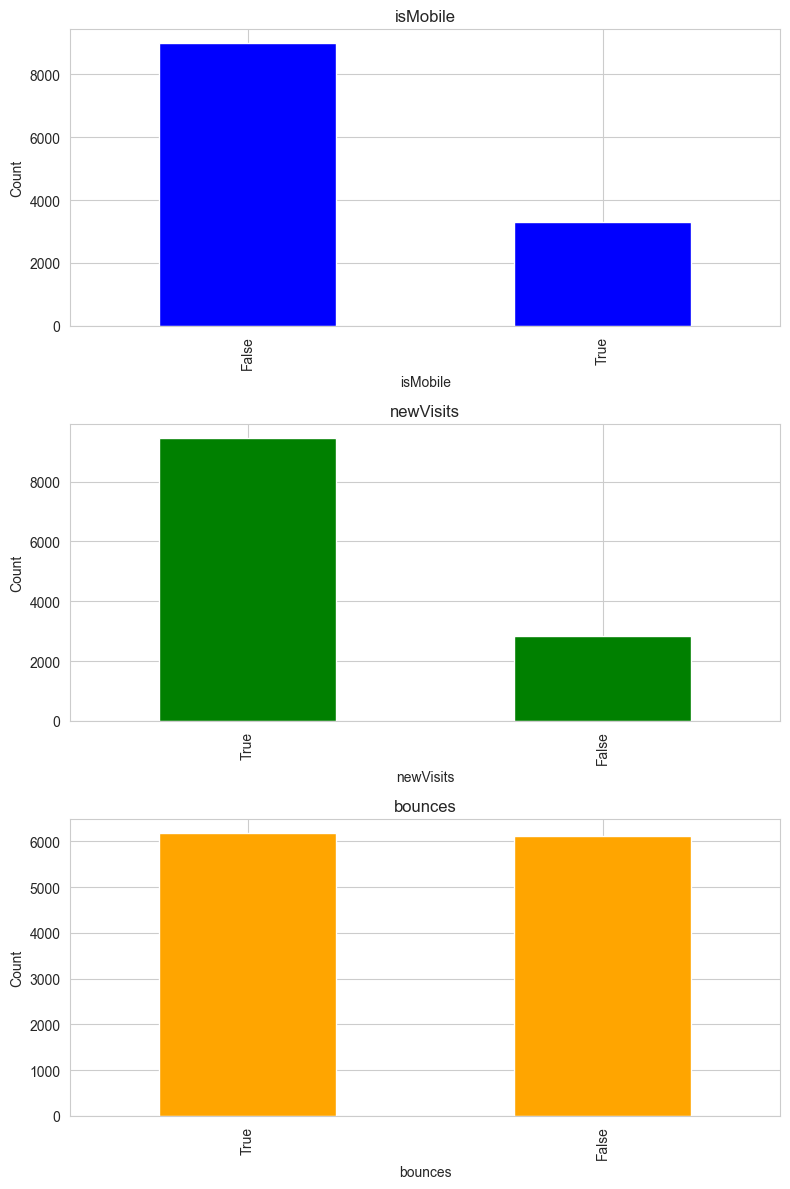

In [114]:
# Establecer el estilo de los gráficos
sns.set_style("whitegrid")

# Crear una figura y ejes para los subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

# Colores personalizados para cada gráfico
colors = ['blue', 'green', 'orange']

# Títulos de los gráficos
titles = ['isMobile', 'newVisits', 'bounces']

# Iterar sobre los subplots y las variables
for i, (column, ax) in enumerate(zip(["isMobile", "newVisits", "bounces"], axes.flatten())):
    df_traffic[column].value_counts().plot(kind="bar", ax=ax, color=colors[i])
    ax.set_title(titles[i])
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Ajustar el diseño de los subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()


#**3.3 Analisis bivariable del Dataset con compras realizadas**


---

In [82]:
#Primero vamos a filtrar los datos de las compras efectivamente realizadas reduciendo el dataset a 164 elementos
filtered_data = df_traffic[df_traffic['transactionRevenue'] != 0]
filtered_data = filtered_data.reset_index(drop=True)

In [93]:
#Ahora toda la información contenida en la columna ya cuenta con información
filtered_data['transactionRevenue']

0       31.49
1      556.61
2       13.59
3       27.19
4       25.90
        ...  
159    144.97
160     19.19
161    489.20
162     23.95
163     25.24
Name: transactionRevenue, Length: 164, dtype: float64

Dado el recorte de los datos a compras realizadas, ahora todas las variables categóricas, están directamente relacionadas con lass compras efectivamente efectuadas, procediendo a analizarlas nuevamente para describir la correlación de las mismas

In [96]:
freq_tbl(filtered_data["channelGrouping"])

,channelGrouping,frequency,percentage,cumulative_perc
0,Referral,67,0.408537,0.408537
1,Organic Search,55,0.335366,0.743902
2,Direct,35,0.213415,0.957317
3,Paid Search,5,0.030488,0.987805
4,Display,2,0.012195,1.000000


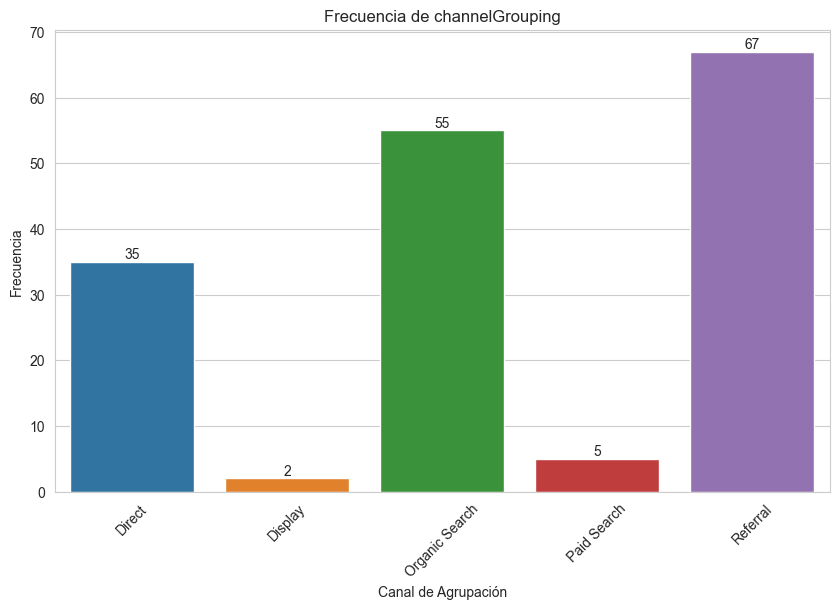

In [170]:
# Calcular las frecuencias de cada categoría de channelGrouping
channel_freq = filtered_data.groupby('channelGrouping').size().reset_index(name='frequency')

# Graficar las frecuencias en un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='channelGrouping', y='frequency', data=channel_freq)
plt.title('Frecuencia de channelGrouping')
plt.xlabel('Canal de Agrupación')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para una mejor visualización

# Agregar los valores específicos de cada categoría en las barras
for index, row in channel_freq.iterrows():
    plt.text(index, row['frequency'], str(row['frequency']), ha='center', va='bottom')

plt.show()


De esta primer visualización podemos darnos cuenta que 67 de las 164 compras realizadas, provienen de enlaces directos referenciados de otros sitios web diferentes a motores de busqueda, esto nos pudiera hacer inferir, que hay una página o páginas haciendo un muy buen de trabajo de marketing al incentivar las compras de los productos y en segundo lugar, los productos comprados, han sido a través de una busqueda orgánica a través de algún navegador

In [200]:
filtered_data["date"].head()

0   2017-06-23
1   2016-08-11
2   2017-06-13
3   2016-11-10
4   2017-06-21
Name: date, dtype: datetime64[ns]

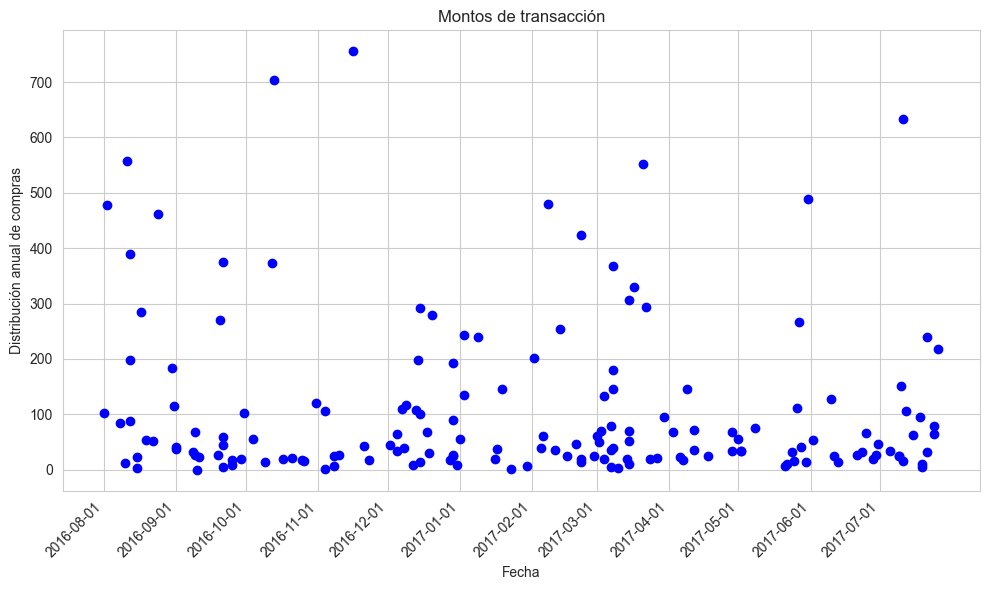

In [231]:
# Crear el gráfico de dispersión de fechas con Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['date'], filtered_data['transactionRevenue'], color='blue')

# Ajustar las etiquetas del eje x para que sean más legibles
plt.xticks(rotation=45, ha='right', ticks=pd.date_range(filtered_data['date'].min(), filtered_data['date'].max(), freq='MS'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))  # Formato de las fechas

# Título y etiquetas de los ejes
plt.title('Montos de transacción')
plt.xlabel('Fecha')
plt.ylabel('Distribución anual de compras')

# Mostrar el gráfico
plt.tight_layout()
plt.show()



De un vistazo general se puede observar que los montos más altos de compra, no están directamente relacionados con los momentos con má ventas en el año y que la mayoría de compras anuales no rebasa los $100 dolares

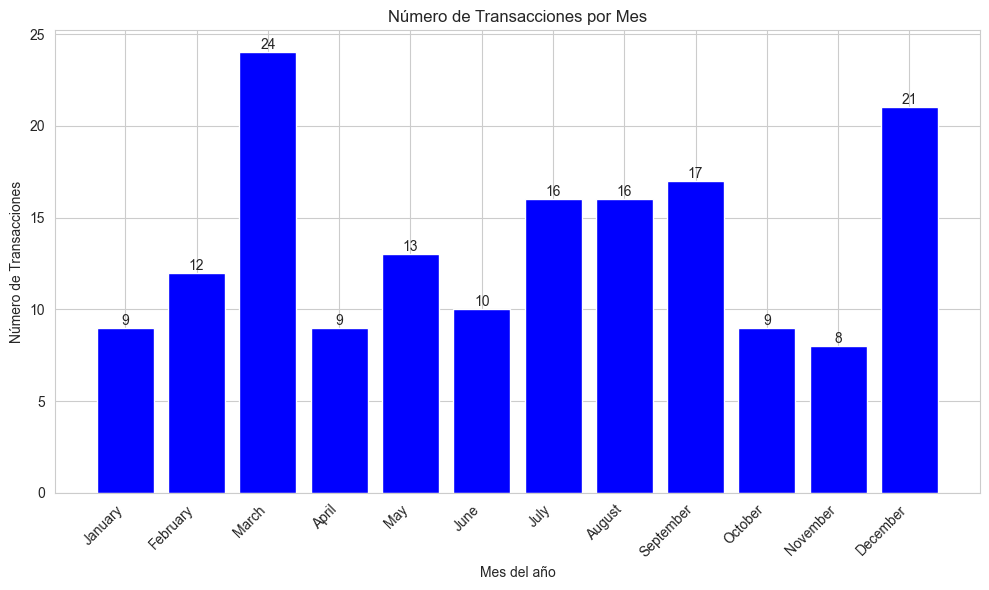

In [241]:
# Calcular el conteo de transacciones por mes
month_counts = filtered_data['month'].value_counts().sort_index()

# Obtener los nombres de los meses
months_names = [calendar.month_name[month] for month in month_counts.index]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(months_names, month_counts.values, color='blue')

# Añadir texto con el valor de cada barra
for i, count in enumerate(month_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Ajustar las etiquetas del eje x para que sean más legibles
plt.xticks(rotation=45, ha='right')

# Título y etiquetas de los ejes
plt.title('Número de Transacciones por Mes')
plt.xlabel('Mes del año')
plt.ylabel('Número de Transacciones')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


A su vez, se aprecia que los meses con mayores ventas fueron los meses de marzo y diciembre, dejando una posibilidad de reforzar las compañas de promoción durante los meses restante y aprovechar para mejorar en los meses que ya demuestran mayor número de ventas

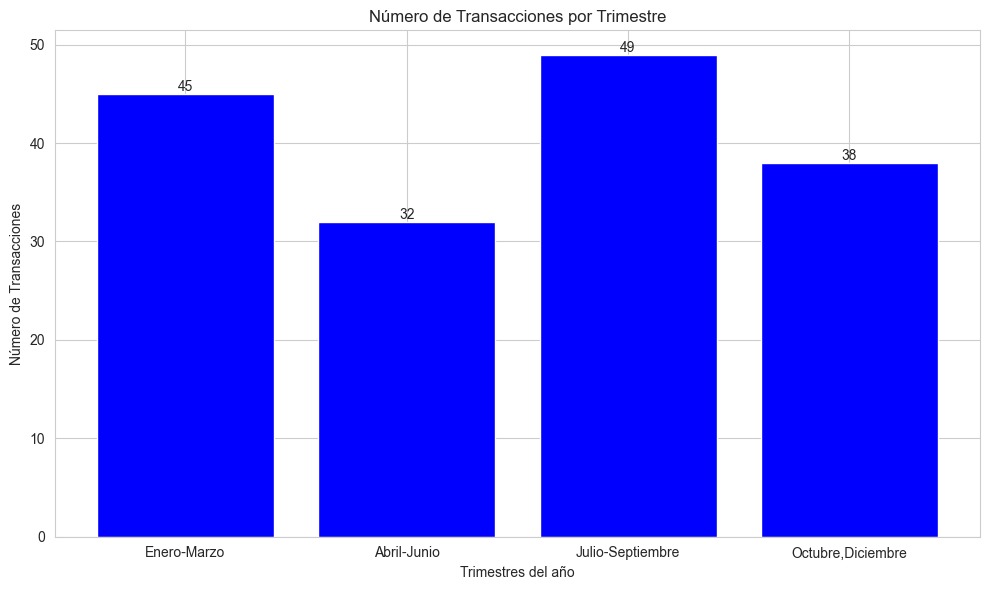

In [244]:
# Calcular el conteo de transacciones por trimestre
quarter_counts = filtered_data['quarterMonth'].value_counts().sort_index()

# Obtener los nombres de los trimestres
quarters_names = ['Enero-Marzo', 'Abril-Junio', 'Julio-Septiembre', 'Octubre,Diciembre']

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(quarters_names, quarter_counts.values, color='blue')

# Añadir texto con el valor de cada barra
for i, count in enumerate(quarter_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Ajustar las etiquetas del eje x para que sean más legibles
plt.xticks(range(len(quarters_names)), quarters_names)

# Título y etiquetas de los ejes
plt.title('Número de Transacciones por Trimestre')
plt.xlabel('Trimestres del año')
plt.ylabel('Número de Transacciones')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Pese a que los meses con mayores ventas fueron marzo y diciembre existe una mayor constancia de compras en el tercer trimestre del año, reflejando una continuidad mayor en las compras y evidenciado la necesidad de buscar estrategias de venta para mejorar el segundo trimestre del año

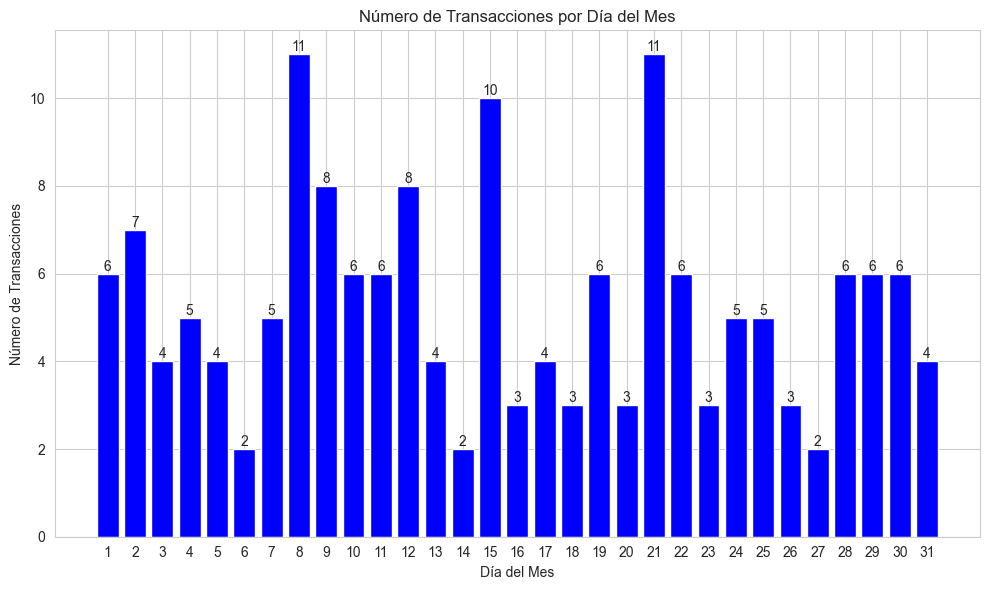

In [250]:
# Calcular el conteo de transacciones por día del mes
day_counts = filtered_data['day'].value_counts().sort_index()

# Obtener los días del mes como una lista de enteros
days = day_counts.index

# Crear el rango de valores para los 31 días del mes
all_days = range(1, 32)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(all_days, [day_counts.get(day, 0) for day in all_days], color='blue')

# Añadir texto con el valor de cada barra
for day in all_days:
    count = day_counts.get(day, 0)
    plt.text(day, count, str(count), ha='center', va='bottom')

# Título y etiquetas de los ejes
plt.title('Número de Transacciones por Día del Mes')
plt.xlabel('Día del Mes')
plt.ylabel('Número de Transacciones')

# Establecer el rango de valores en el eje x para mostrar los 31 días
plt.xticks(all_days)

# Mostrar el gráfico
plt.tight_layout()
plt.show()



Observar la tendencia del día del mes en que se realizan las compras, nos genera una perspectiva distinta a los esperado, ya que el mayor número de compras no solo se realizó a finales o principios de quincena, sino que a finales de mes, se ve una tendencia por la disminución de las compras

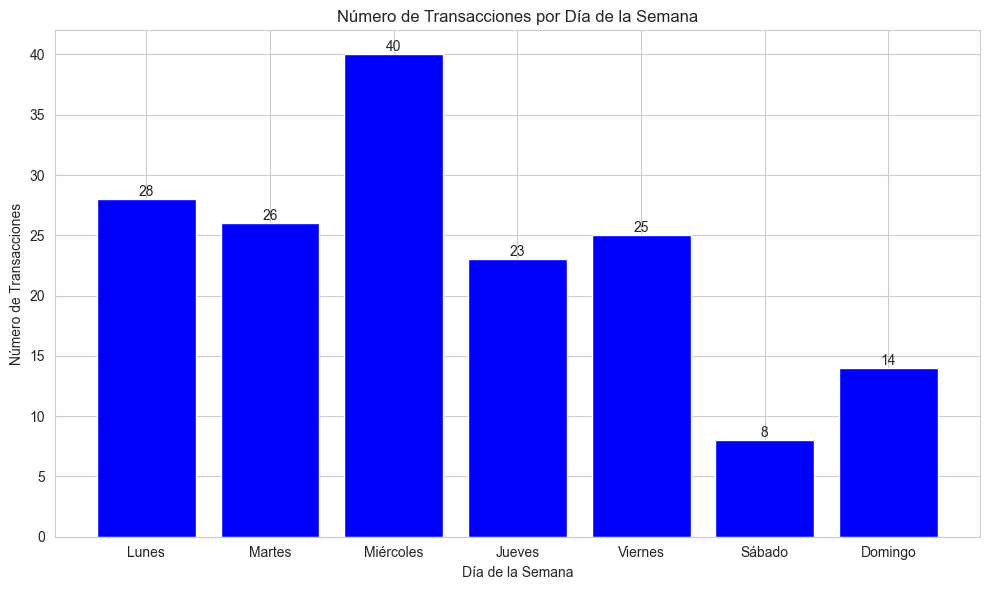

In [253]:
# Calcular el conteo de transacciones por día de la semana
weekday_counts = filtered_data['weekday'].value_counts().sort_index()

# Obtener los días de la semana como una lista de enteros
weekdays = weekday_counts.index

# Nombres de los días de la semana
weekday_names = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(weekdays, weekday_counts.values, color='blue')

# Añadir texto con el valor de cada barra
for weekday, count in zip(weekdays, weekday_counts.values):
    plt.text(weekday, count, str(count), ha='center', va='bottom')

# Establecer los nombres de los días de la semana como etiquetas del eje x
plt.xticks(weekdays, weekday_names)

# Título y etiquetas de los ejes
plt.title('Número de Transacciones por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Número de Transacciones')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


El pico de ventas, se refleja entre semana, por lo tanto, el objeto de ventas, puede ser utulizado para alguna actividad empresarial, gubernamental o de oficina, ya que los fines de semana disminuye considerablemente el nivel de ventas y se infiere a que es debido a que los consumidores cuentan mayormente con esos días de descanso

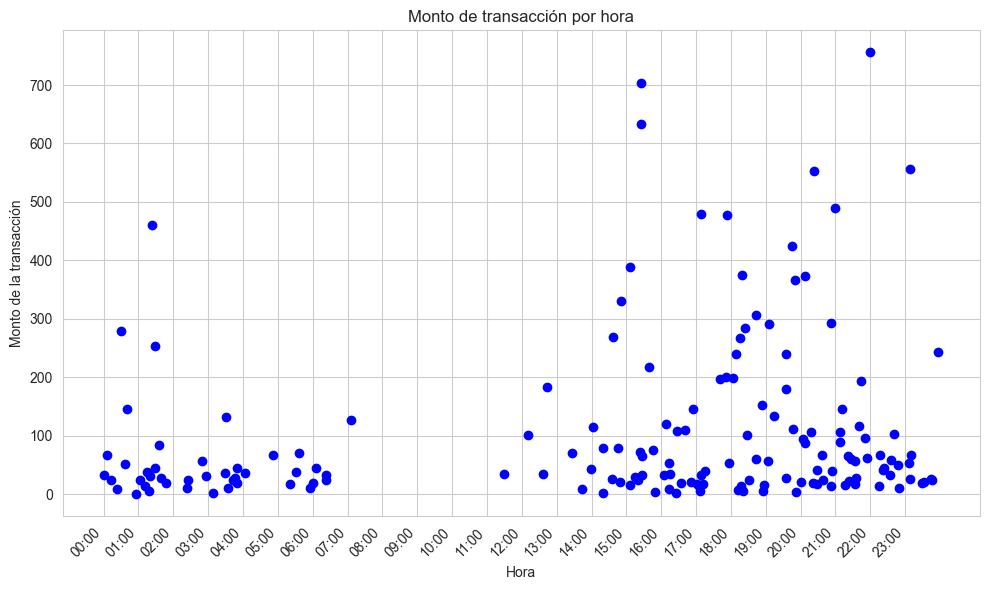

In [235]:
# Convertir la columna 'visitStartTime' a tipo de dato de fecha
filtered_data['visitStartTime'] = pd.to_datetime(filtered_data['visitStartTime'])

# Obtener la fecha mínima y máxima
min_date = filtered_data['visitStartTime'].min().replace(minute=0, second=0)
max_date = filtered_data['visitStartTime'].max().replace(minute=0, second=0, microsecond=0)

# Generar las marcas de tiempo para cada hora del día
ticks = pd.date_range(start=min_date, end=max_date, freq='H')

# Crear el gráfico de dispersión de fechas con Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['visitStartTime'], filtered_data['transactionRevenue'], color='blue')

# Ajustar las etiquetas del eje x para que sean más legibles
plt.xticks(rotation=45, ha='right', ticks=ticks)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))  # Formato de las horas

# Título y etiquetas de los ejes
plt.title('Monto de transacción por hora')
plt.xlabel('Hora')
plt.ylabel('Monto de la transacción')

# Mostrar el gráfico
plt.tight_layout()
plt.show()



Las horas de compra reflejan un mayor consumo en la tarde y madrugada de los días, dejando un gran lapso de tiempo en las mañanas en donde no existen consumos, pero puede verse directamente relacionado con los horarios laborales de oficina más comunes en los consumidores.

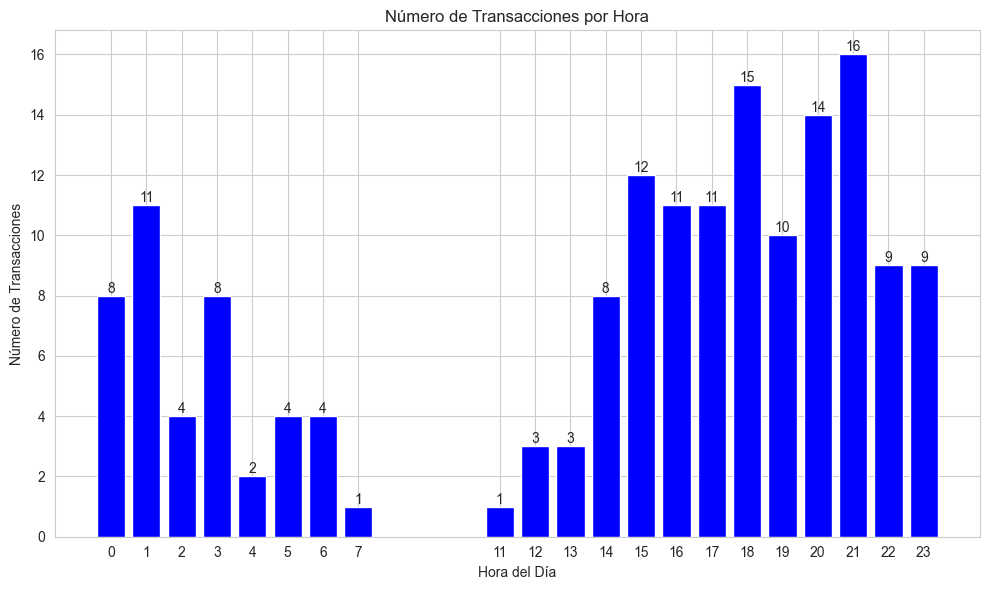

In [234]:
# Calcular el conteo de transacciones por hora
hour_counts = filtered_data['hour'].value_counts().sort_index()

# Extraer la hora como un entero
hours = [hour.hour for hour in hour_counts.index]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(hours, hour_counts.values, color='blue')

# Añadir texto con el valor de cada barra
for hour, count in zip(hours, hour_counts.values):
    plt.text(hour, count, str(count), ha='center', va='bottom')

# Ajustar las etiquetas del eje x para que sean más legibles
plt.xticks(hours)

# Título y etiquetas de los ejes
plt.title('Número de Transacciones por Hora')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Transacciones')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Aquí podemos observar más claramente que los picos de ventas incrementan a partir de los posibles horarios de comida en adelante, asumiendo que gran parte del público pudiera desempeñar algún tipo de trabajo de oficina enter 9:00 a 18:00 horas 

In [218]:
#filtered_data['visitStartTime'] = filtered_data['visitStartTime'].dt.strftime('%H:%M')

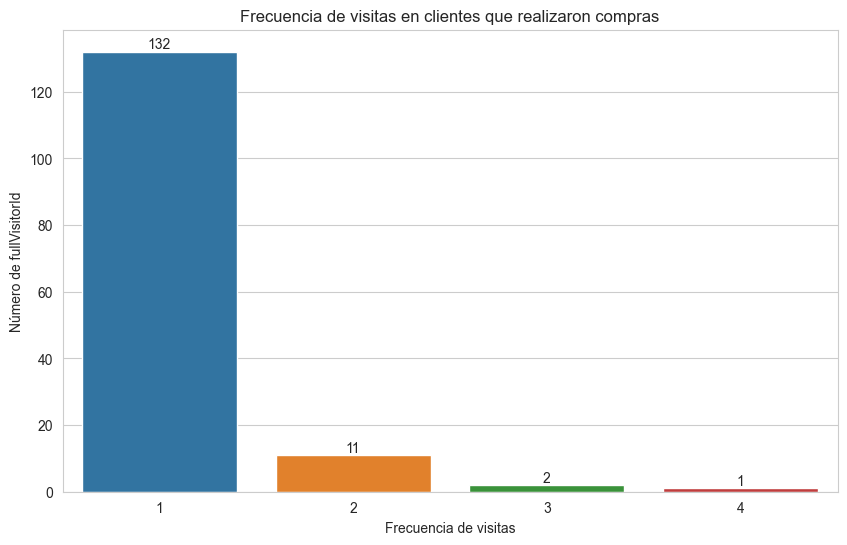

In [169]:
# Calcular las frecuencias de repetición de visitas de cada fullVisitorId
visit_freq = filtered_data['fullVisitorId'].value_counts().reset_index(name='frequency')

# Calcular las frecuencias de las frecuencias (sí, suena confuso, pero básicamente estamos contando cuántos fullVisitorId tienen la misma frecuencia)
frequency_freq = visit_freq['frequency'].value_counts().reset_index(name='id_count')


# Graficar las frecuencias de visitas en un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='id_count', data=frequency_freq)
plt.title('Frecuencia de visitas en clientes que realizaron compras')
plt.xlabel('Frecuencia de visitas')
plt.ylabel('Número de fullVisitorId')
plt.xticks(rotation=0)

# Agregar los valores específicos de cada categoría en las barras
for index, row in frequency_freq.iterrows():
    plt.text(row['frequency'] - 1, row['id_count'], str(row['id_count']), ha='center', va='bottom')


plt.show()



De la información antes mostrada, podemos darnos cuenta, que de las 146 compras realizadas, un 90% la realizó en su primer visita el 10% restante le tomó entre 2 y 4 visitas realizar su compra, predominando un máximo de 2 visitas 